In [2]:
import numpy as np
import pandas as pd
import kmapper as km
import kneed
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from networkx.readwrite import json_graph
import json
import collections
from dataclasses import dataclass
import ast
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from diskcache import Cache
from scipy.stats import entropy

sns.set()
cache = Cache('./cachev3/')

In [3]:
NUM_EPOCHS = 176
LAYER = 12
DATA = 'train'

In [4]:
@dataclass
class Config:
    iteration: int = 0
    metric: str = 'euclidean'
    filter_func: str = 'l2'
    intervals: int = 50
    overlap: float = 0.5
    min_samples: int = 5


def read_labels(path):
    label_data = []
    with open(path, 'r') as f:
        for line in f:
            word_info, word_label = line.strip().split('\t')
            sent_info, word = word_info.split(':')
            sent_info = ast.literal_eval(sent_info)
            label_data.append([sent_info[0], sent_info[1], word, word_label])

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def add_node_metadata(graph, metadata_source, activations):
    # create PCA model first
    nodewise_activations = np.vstack([np.mean(activations.iloc[graph['nodes'][node_name]], axis=0) for node_name in graph['nodes']])

    for i, node_name in enumerate(graph['nodes']):
        member_list = graph['nodes'][node_name]

        metadata = [metadata_source.loc[member_index].tolist() for member_index in member_list]
        graph['nodes'][node_name] = {'membership_ids': member_list, 'metadata': metadata,
                                     'l2avg': np.average(metadata_source.loc[member_list]['l2norm']),
                                     'type': 'train'}

    return graph


def elbow_eps(data):
    nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[::-1]
    kneedle = kneed.KneeLocator(distances[:, 1], np.linspace(0, 1, num=len(distances)), curve='convex', direction='decreasing')
    eps = kneedle.knee * 0.75 if kneedle.knee else 5
    return eps


def serialize_graph(graph):
    nx_graph = km.adapter.to_networkx(graph)
    js_graph = json_graph.node_link_data(nx_graph)

    for i, node in enumerate(js_graph['nodes']):
        js_graph['nodes'][i]['name'] = js_graph['nodes'][i]['id']
        js_graph['nodes'][i]['l2avg'] = js_graph['nodes'][i]['membership']['l2avg']

    for i, link in enumerate(js_graph['links']):
        id_s = link['source']
        id_t = link['target']
        mem1 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_s][0]
        mem2 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_t][0]
        mem1, mem2 = set(mem1), set(mem2)
        jaccard = len(mem1.intersection(mem2)) / len(mem1.union(mem2))
        js_graph['links'][i]['intersection'] = jaccard

    return js_graph


def get_mapper(activations, labels, conf):
    labels['l2norm'] = np.expand_dims(np.linalg.norm(activations.to_numpy(), axis=1), 1)
    mapper = km.KeplerMapper()

    if conf.filter_func == 'l1':
        projected_data = np.linalg.norm(activations, ord=1, axis=1).reshape((activations.shape[0], 1))
    elif conf.filter_func == 'l2':
        projected_data = mapper.fit_transform(activations, projection='l2norm')
    elif conf.filter_func == 'knn5':
        projected_data = mapper.fit_transform(activations, projection='knn_distance_5') / 5
    else:
        raise KeyError('Unexpected filter function')

    eps = elbow_eps(activations)
    graph = mapper.map(projected_data, activations, clusterer=DBSCAN(eps=eps, metric=conf.metric, min_samples=conf.min_samples),
                       cover=km.Cover(n_cubes=conf.intervals, perc_overlap=conf.overlap))

    add_node_metadata(graph, labels, activations)

    return serialize_graph(graph)


def node_purity(node, label):
    metadata = node['membership']['metadata']
    label_counts = collections.Counter([x[3] for x in metadata])
    return (label_counts[label], len(metadata), label)


def compute_purities(graph):
    point_node_purities = collections.defaultdict(list)

    for node in graph['nodes']:
        metadata = node['membership']['metadata']

        for i, point_id in enumerate(node['membership']['membership_ids']):
            point_node_purities[point_id].append((i, node_purity(node, metadata[i][3])))

    return point_node_purities


def get_activations_labels(activation_file, label_file):
    activations = pd.read_csv(activation_file, delim_whitespace=True, header=None)
    labels = read_labels(label_file)
    return activations, labels


def get_graph(config, caching=True):
    layer = LAYER

    ACTIVATION_FILE = f'../backend/data/ss-role/fine-tuned-bert-base-uncased/{DATA}/{config.iteration}/{layer}.txt'
    label_file = f'../backend/data/ss-role/entities/{DATA}.txt'


    cache_key = f'{ACTIVATION_FILE}-{label_file}-{config}'

    if caching and cache_key in cache:
        graph = cache[cache_key]
    else:
        activations, labels = get_activations_labels(ACTIVATION_FILE, label_file)
        graph = get_mapper(activations, labels, config)
        cache[cache_key] = graph

    return graph

In [5]:
# caching run
graphs = []

for fileindex in tqdm(range(0, NUM_EPOCHS, 5)):
    config = Config(iteration=fileindex, metric='euclidean', filter_func='l2', intervals=50, overlap=0.5, min_samples=3)
    graphs.append(get_graph(config, caching=True))

labels = sorted(read_labels(f'../backend/data/ss-role/entities/{DATA}.txt').label.unique().tolist())
# convert label to dict with positions as value
label_dict = {label: i for i, label in enumerate(labels)}

  0%|          | 0/36 [00:00<?, ?it/s]

In [7]:
def compute_nodewise_purities(graphs):
    entropy_bound = entropy(np.array([1] * len(labels)) / len(labels))

    def node_purities(graph):
        purities = []
        for node in graph['nodes']:
            n_purity = [0] * len(labels)
            metadata = node['membership']['metadata']
            label_counts = collections.Counter([x[3] for x in metadata])

            for label, count in label_counts.items():
                n_purity[label_dict[label]] = count / len(metadata)

            purities.append(1 - entropy(n_purity) / entropy_bound)
            
        return purities

    nodewise_purities = []

    for iteration, graph in enumerate(graphs):
        nodewise_purities.append(node_purities(graph))

    return nodewise_purities

In [8]:
nodewise_purities = compute_nodewise_purities(graphs)
df_nodewise_purities = pd.DataFrame([[x * 5, y] for x, y in enumerate(nodewise_purities)])
df_nodewise_purities.columns = ['iteration', 'purity']
# df_nodewise_purities

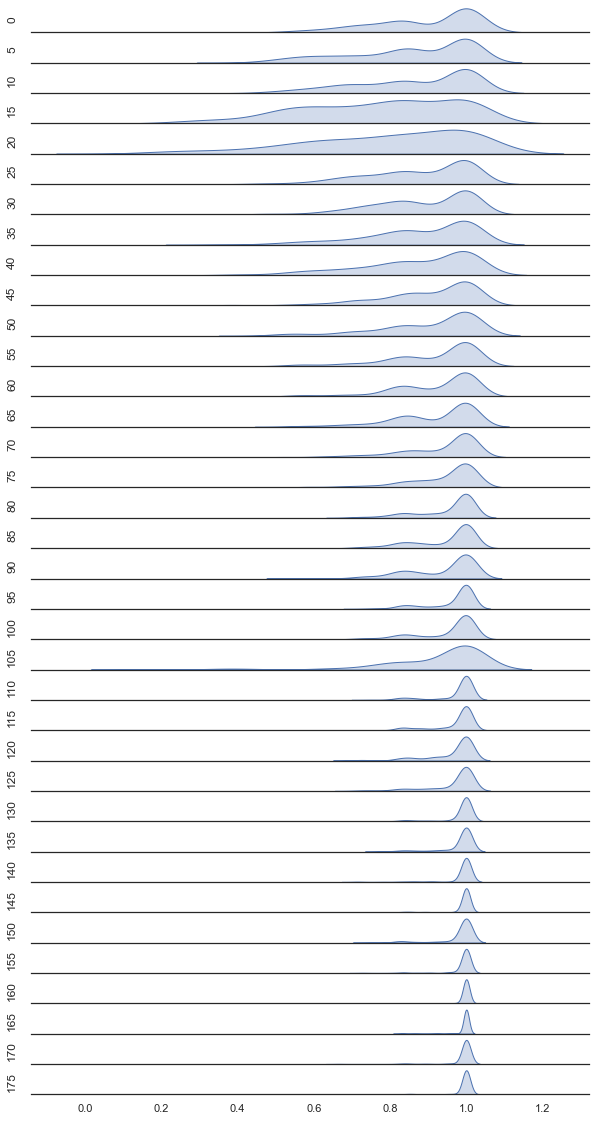

In [51]:
# compute kde estimate for purity lists for each iteration
fig, axes = plt.subplots(nrows=len(df_nodewise_purities), ncols=1, figsize=(10, 20), sharex=True)
for i, ax in enumerate(axes):
    purities = df_nodewise_purities.iloc[i]['purity']
    sns.kdeplot(purities, ax=ax, shade=True)
    ax.set_xlabel('')
    ax.set_ylabel(i*5)
    ax.set_yticklabels([])
    # remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.set_title(f'iteration {i * 5}')

# set hspace
# fig.subplots_adjust(hspace=-0.1)
# plt.suptitle('KDE estimate of node purity')
# plt.tight_layout()

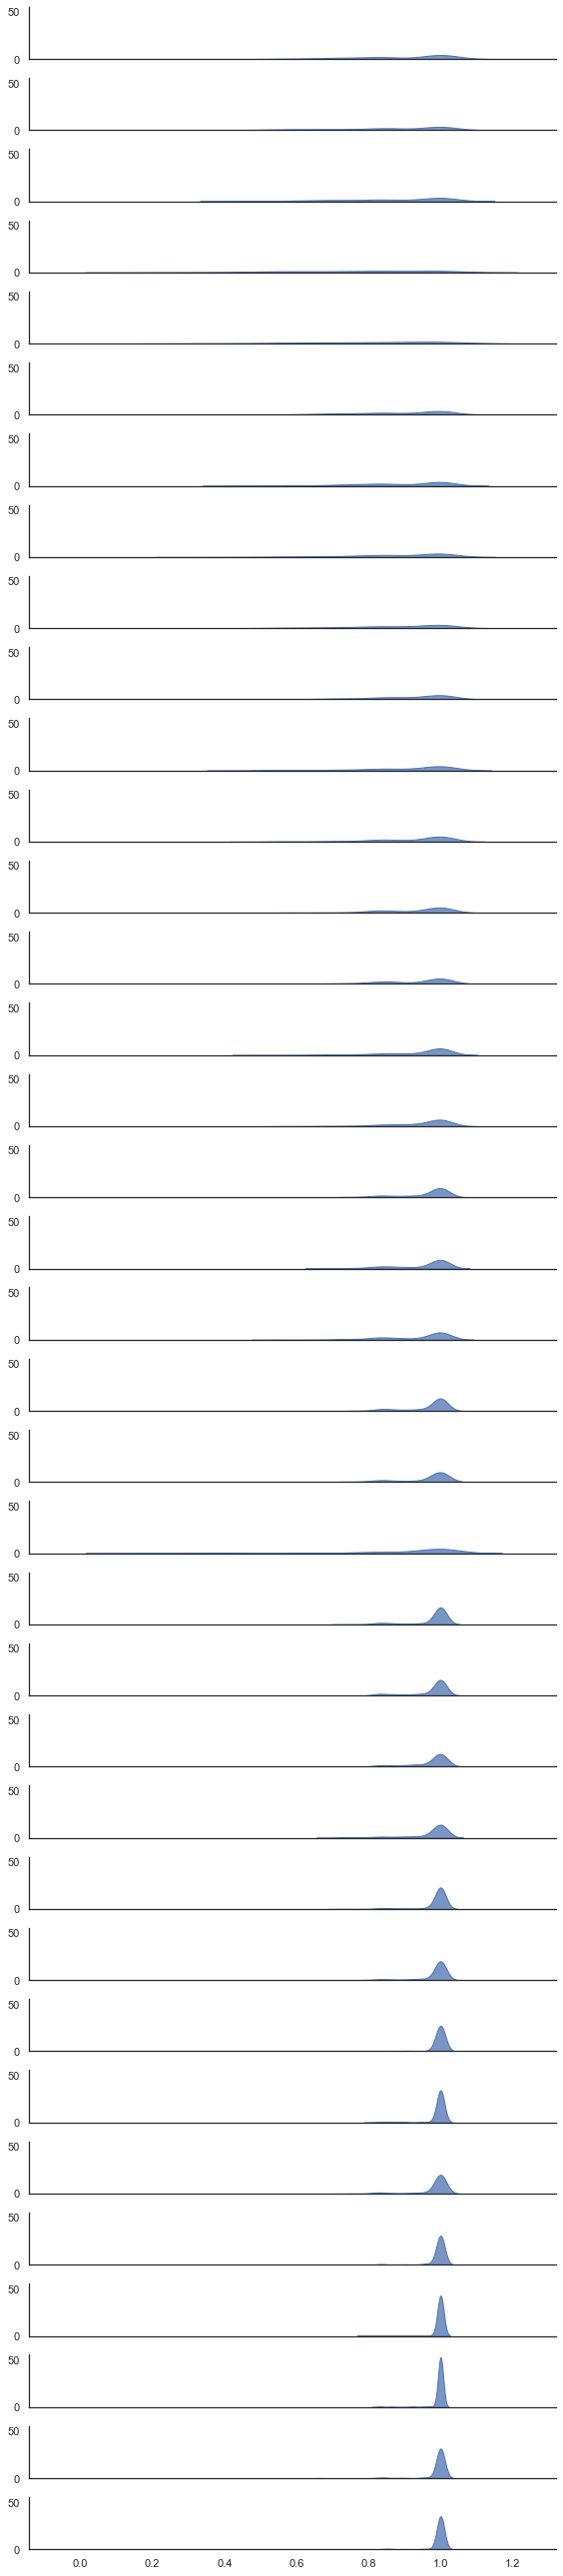

In [22]:
# draw each graph's node purities as a distribution on a faceted grid
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})
pal = sns.color_palette("crest")

g = sns.FacetGrid(df_nodewise_purities, row='iteration', aspect=8, height=1, palette=pal)
# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# g.map_dataframe(sns.kdeplot, 'purity', hist=False, rug=True, kde_kws={'shade': True})

for i, ax in enumerate(g.axes.flat):
    # ax.set_title(f'Iteration {i * 5}')
    # ax.set_xlabel('Purity')
    # ax.set_ylim(0, 5)
    # ax.set_xlim(0, 1)
    sns.kdeplot(df_nodewise_purities.iloc[i, 1], ax=ax, fill=True, alpha=0.75)
    # ax.hist(df_nodewise_purities.loc[df_nodewise_purities['iteration'] == i * 5, 'purity'], bins=10, color=pal[i % len(pal)])


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.95)
# g.set_titles("")
g.set(ylabel="")
# g.despine(bottom=True, left=True)
plt.tight_layout()